### GHP Construction with Duration Matching

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline
import risk_toolkit as rk
import pandas as pd
import numpy as np

In [3]:
rk.bond_price(3, 100, 0.03, 2)

100.00000000000007

In [4]:
rk.bond_cf(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

### Bond prices change with interest rates

<AxesSubplot:title={'center':'Change in 10y bond prices with interest rates'}>

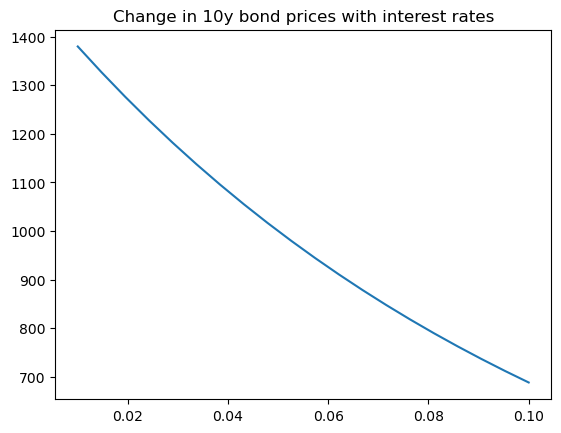

In [5]:
rates = np.linspace(0.01, 0.10, num=20)

prices = [rk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]

pd.DataFrame(data=prices, index=rates).plot(title='Change in 10y bond prices with interest rates', legend=False)

In [6]:
cf = rk.bond_cf(3, 1000, 0.06, 2)

In [7]:
discounts = rk.discount(cf.index, 0.06/2)

In [8]:
dcf = discounts * cf

In [9]:
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [10]:
weights = dcf / dcf.sum()

In [11]:
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [12]:
(cf.index * weights).sum()

5.579707187194534

In [13]:
rk.macaulay_duration(rk.bond_cf(3, 1000, .06, 2), 0.06/2)

5.579707187194534

### Duration matching

In [14]:
liabilities = pd.Series(data=[100000, 100000], index=[10, 12]) # I have 2 liabilities, a 10y and a 12y liability.

rk.macaulay_duration(liabilities, 0.04)

10.960799385088393

Now assume we have two types of bonds available. We have a 10 year bond and a 20 year bond. Each of them pays a 5% coupon once a year and has a face value of \\$1000. What are the durations of these bonds?

In [15]:
md_10 = rk.macaulay_duration(rk.bond_cf(10, 1000, 0.05, 1), 0.04)

In [16]:
md_20 = rk.macaulay_duration(rk.bond_cf(20, 1000, 0.05, 1), 0.04)

In [17]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

In [18]:
short_bond = rk.bond_cf(10, 1000, 0.05, 1)

long_bond = rk.bond_cf(20, 1000, 0.05, 1)

w_s = rk.match_durations(liabilities, long_bond, short_bond, 0.04)

w_s

0.48263092069478974

In [20]:
p_short = rk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = rk.bond_price(20, 1000, 0.05, 1, 0.04)

a_0 = 130000

port_flows = pd.concat([a_0 * w_s * short_bond / p_short, a_0 * (1 - w_s) * long_bond / p_long])

rk.macaulay_duration(port_flows, 0.04)

10.960799385088393

This is the same of the duration of the liabilities

In [21]:
curr_funding_ratio = rk.funding_ratio(port_flows, liabilities, 0.04)

In [22]:
curr_funding_ratio

0.9998760012192478

<AxesSubplot:title={'center':'Funding ratios with changes in interest rates'}>

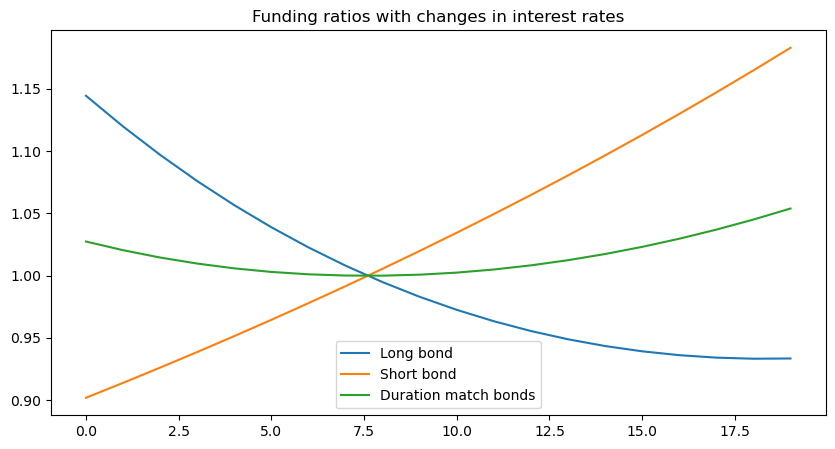

In [24]:
rates = np.linspace(0, 0.1, 20)

long_bond_assets = a_0 * long_bond / p_long

short_bond_assets = a_0 * short_bond / p_short

fund_ratio_chang = pd.DataFrame({
    'Long bond': [rk.funding_ratio(long_bond_assets, liabilities, r) for r in rates],
    'Short bond': [rk.funding_ratio(short_bond_assets, liabilities, r) for r in rates],
    'Duration match bonds': [rk.funding_ratio(port_flows, liabilities, r) for r in rates]
})

fund_ratio_chang.plot(title='Funding ratios with changes in interest rates', figsize=(10,5))